In [221]:
import geopandas as gpd
from src.model_selection import split_data, get_ffs_features, get_metrics_summary
from src.transformations import get_predictors
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [308]:
%%time

# MODELING PIPELINE

ams = gpd.read_parquet("data/output/amsterdam_h3_res_8_processed.parquet")
krk = gpd.read_parquet("data/output/krakow_h3_res_8_processed.parquet")

target = "bike_paths_len"
predictors = get_predictors(ams, target)

lr = LinearRegressionModelBuilder(predictors=predictors, 
                                  target_feature=target)
lr.set_data(ams)
# lr.standardize_data()
lr.split_data()
lr.forward_feature_selection(num_features=6)
lr.build_model()
lr.predict()
lr.force_positive_predictions()
lr.calculate_metrics_values()
print(lr.metrics_values)

lr.set_data(krk)
# lr.standardize_data()
lr.split_data(test_size=1)
lr.predict()
# lr.force_positive_predictions()
lr.calculate_metrics_values()
print(lr.metrics_values)

{'mse': 1204952.997788047, 'r2': 0.645441144174413, 'mae': 868.7288804582347, 'mape': 4.056499548786583e+17}
{'mse': 6368139.299155658, 'r2': -6.994228269152981, 'mae': 2284.9561915901913, 'mape': 4.5451897854988595e+18}
CPU times: total: 9.89 s
Wall time: 9.98 s


In [307]:
# zrobic baseline za pomoca a i b ze wzorow
# parallelizm dla forward feature selection

# Add README.md
# Add env.yml
# Add logging

In [274]:
from abc import ABC, abstractmethod

class ModelBuilder(ABC):
    @abstractmethod
    def __init__(self, predictors, target_feature, log_mlflow=False, experiment_name=""):
        self.predictors = predictors
        self.target_feature = target_feature
        self.model = None
        self.hyperparams = {}
        self.use_validation_set = False
        self.predictions = []
        self.metrics_values = {}
        self.log_mlflow = log_mlflow
        self.scaler = None
        if self.log_mlflow:
            now = datetime.datetime.now()
            mlflow.set_experiment(f"{experiment_name}_{now.strftime('%m-%d-%Y_%H-%M-%S')}")
            
    def set_model(self, model):
        self.model = model
            
    def set_data(self, data):
        self.data = data.copy()
        
    def split_data(self, test_size=0.2, validation_set=False):
        if test_size == 1:
            self.test_set = self.data
        else:
            self.train_set, self.test_set = train_test_split(self.data, test_size=test_size, random_state=42)
            if validation_set:
                self.train_set, self.validation_set = train_test_split(self.train_set, test_size=test_size/(1-test_size), random_state=42)
                self.use_validation_set = True
            
    def build_model(self):
        self.model_build = self.model(**self.hyperparams)
        self.model_build.fit(self.train_set[self.predictors], self.train_set[self.target_feature])
    
    def predict(self):
        self.predictions = self.model_build.predict(self.test_set[self.predictors])
        
    def calculate_metrics_values(self):
        actual = self.test_set[self.target_feature]
        predicted = self.predictions
        self.metrics_values = {
        "mse": mean_squared_error(actual, predicted),
        "r2": r2_score(actual, predicted),
        "mae": mean_absolute_error(actual, predicted),
        "mape": mean_absolute_percentage_error(actual, predicted),
        }
    def save_model_to_pickle(self, model_name):
        with open(f'models/{model_name}.pkl','wb') as file:
            pickle.dump(self.model_build, file)
    
class LinearRegressionModelBuilder(ModelBuilder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.model = LinearRegression
        
    def forward_feature_selection(self, num_features=6, log_mlflow=False, scoring="neg_mean_squared_error"
    ):
        predictors_data = self.train_set[self.predictors].astype(float)
        target_data = self.train_set[self.target_feature].astype(float)

        remaining_features = self.predictors
        best_features = []

        for round_ in range(num_features):
            scores_with_candidates = []
            for candidate in remaining_features:
                features = best_features + [candidate]
                model = self.model(**self.hyperparams)
                mse_scores = -cross_val_score(model, predictors_data[features], target_data, scoring=scoring)
                score = np.mean(mse_scores)
                scores_with_candidates.append((score, candidate))
                if self.log_mlflow:
                    with mlflow.start_run():
                        mlflow.log_param("predictors", features)
                        mlflow.log_metrics({"mse": score})
                        mlflow.sklearn.log_model(
                            sk_model=model,
                            artifact_path="sklearn-model",
                            registered_model_name="sk-learn-linear-reg-model",
                        )
            _, best_candidate = sorted(scores_with_candidates)[0]
            best_features.append(best_candidate)
            remaining_features = list(set(remaining_features).difference(set(predictors_data.columns[np.abs(predictors_data.corr()[best_candidate])>0.7])))
            if not remaining_features:
                print("FFS finished at round", round_)
                self.predictors = best_features
                return 
        self.predictors = best_features
        
    def force_positive_predictions(self):
        self.predictions = np.maximum(self.predictions, 0)

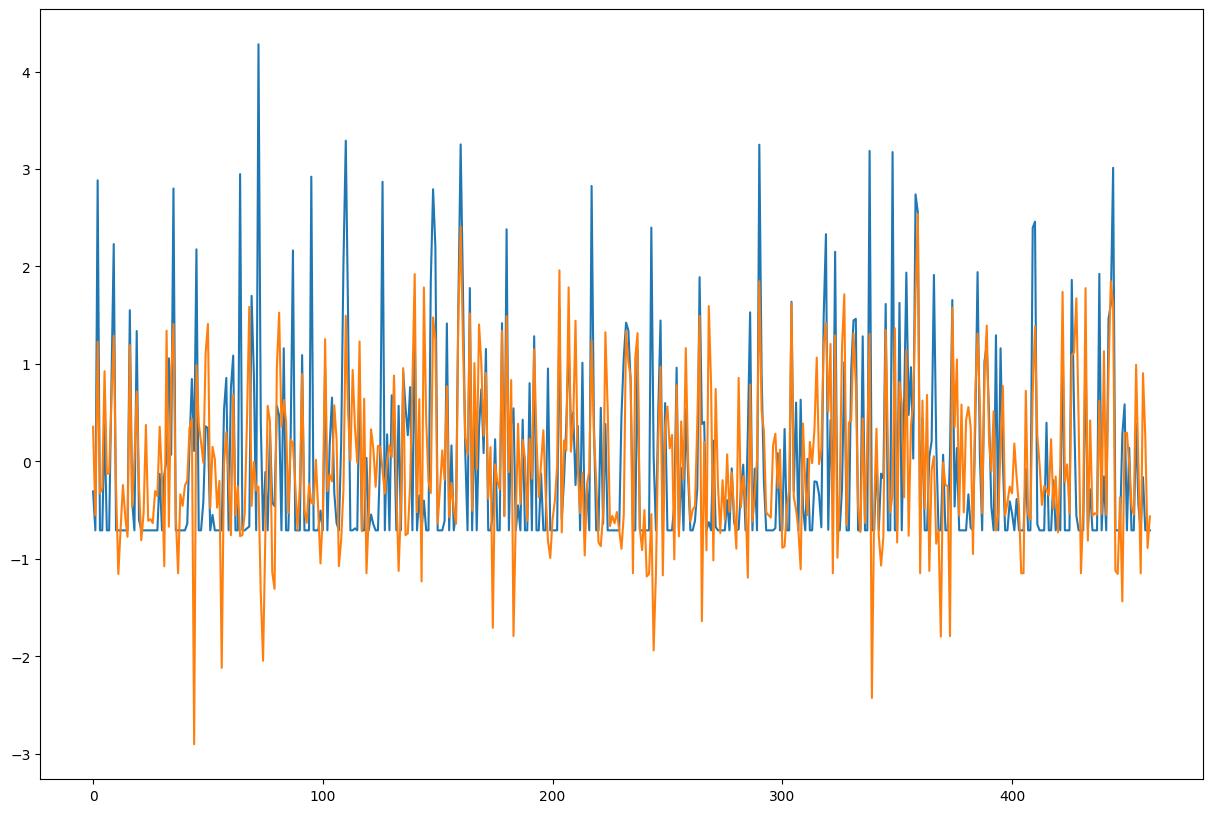

In [301]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1,1, figsize=(15,10))
ax.plot(range(0,len(lr.predictions)), lr.test_set[lr.target_feature])
ax.plot(range(0,len(lr.predictions)), lr.predictions)
# ax.set_title(get_metrics_summary(y_test, y_test_pred))

In [ ]:
########################################################